In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [7]:
!ls /home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_features/gt/pooled/

bigdet_features		   coco_features
bigdet_finetune_on_esmart  coco_finetune_on_esmart


In [17]:
## ROI pooled embeddings (7x7x256)

In [3]:
with open('classwise_GTfeatures.pkl', 'rb') as f:
        embed_classwise = pickle.load(f)

In [8]:
embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_features/gt/pooled/"

In [9]:
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

In [11]:
# Extract embeddings and corresponding class labels
all_embeddings = []
class_labels = []
for class_label, embeddings in embed_classwise.items():
    all_embeddings.extend(embeddings)
    class_labels.extend([class_label] * len(embeddings))

# Convert to numpy arrays
all_embeddings = np.array(all_embeddings)
class_labels = np.array(class_labels)
num_sample = class_labels.shape[0]
all_embeddings = all_embeddings.reshape(num_sample,-1)

del embed_classwise

In [12]:
all_embeddings.shape,class_labels.shape

((77051, 12544), (77051,))

In [13]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=1024)  # Adjust the number of components as needed
pca_embeddings = pca.fit_transform(all_embeddings)

# Compute t-SNE embeddings on PCA embeddings
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(pca_embeddings)

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


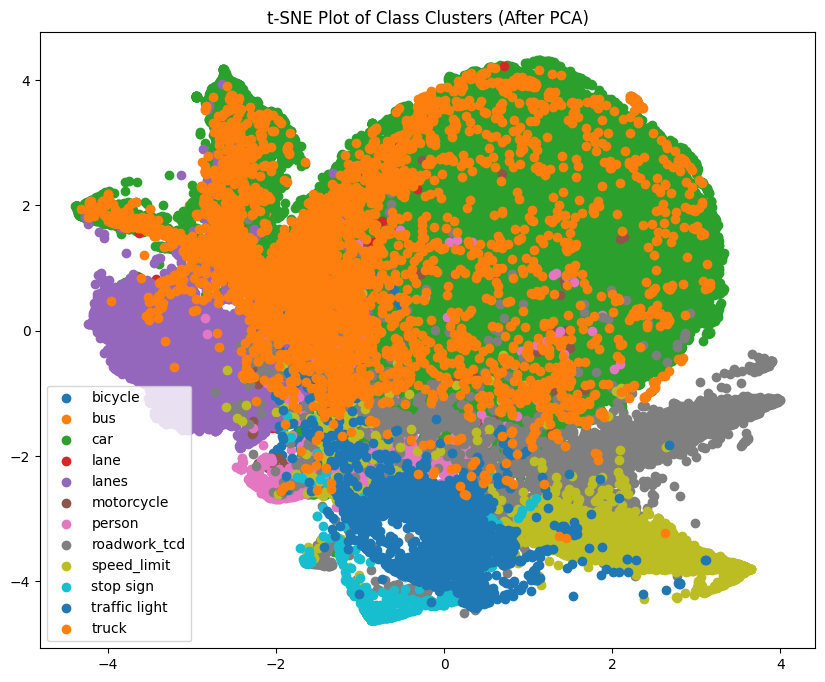

In [14]:
# Create a scatter plot
plt.figure(figsize=(10, 8))
unique_labels = np.unique(class_labels)
for label in unique_labels:
    indices = np.where(class_labels == label)
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=label)

plt.title('t-SNE Plot of Class Clusters (After PCA)')
plt.legend([
                        "bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"
                          ])
plt.show()

## Train linear SVM to as measure of seperability

In [15]:
from sklearn import svm

In [19]:
#del all_embeddings
#pca_embeddings.shape

In [16]:
clf = svm.LinearSVC()
clf.fit(all_embeddings, class_labels)

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
y_pred = clf.predict(all_embeddings)
y = class_labels

# Calculate and display training metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

print("Training Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Training Metrics:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


## Qualitative testing on OOD samples

In [2]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import cv2
from detectron2.data.datasets import register_coco_instances

In [3]:
#register dataset
def register_esmart_wip(root = "/home/vaibhav/Desktop/stud/datasets/esmart/"):
        things_classes = ["bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"]
        name = 'esmart_wip'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'labels_mod.json'),
                        os.path.join(root, 'data/'),
                    )

register_esmart_wip()

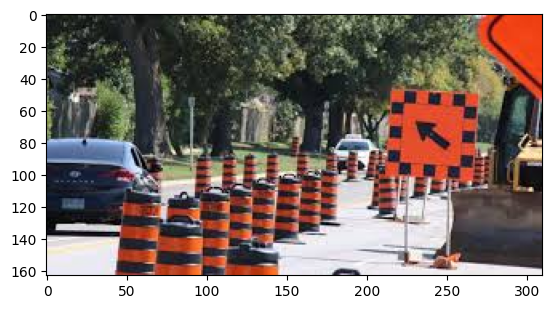

In [4]:
im = cv2.imread("/home/vaibhav/Desktop/stud/datasets/esmart/test/3.jpeg")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [4]:
cfg = get_cfg()
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml")
# Create predictor
cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/bigdet_finetune_on_esmart/model_final.pth"
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=True)
#cfg.MODEL.WEIGHTS = "/home/vaibhav/Desktop/ood_distance/checkpoints/faster_rcnn_r50_fpn_bigdet_8x.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

# Make prediction
# outputs = predictor(im)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_bigdet_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.


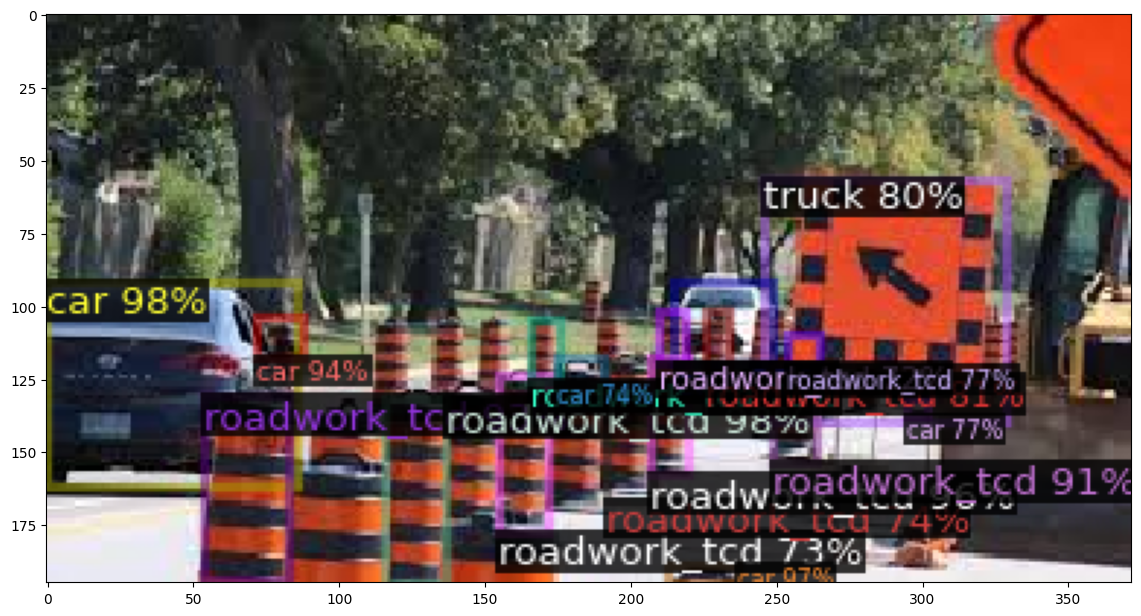

In [6]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

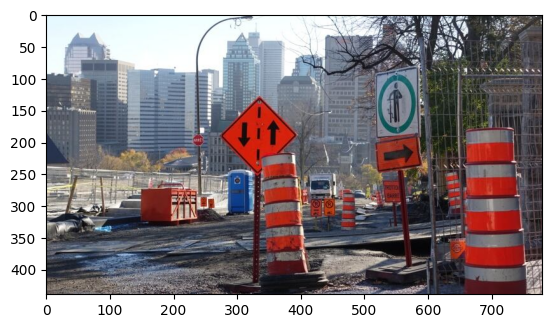

In [5]:
im1 = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/montreal-construction.jpeg")
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


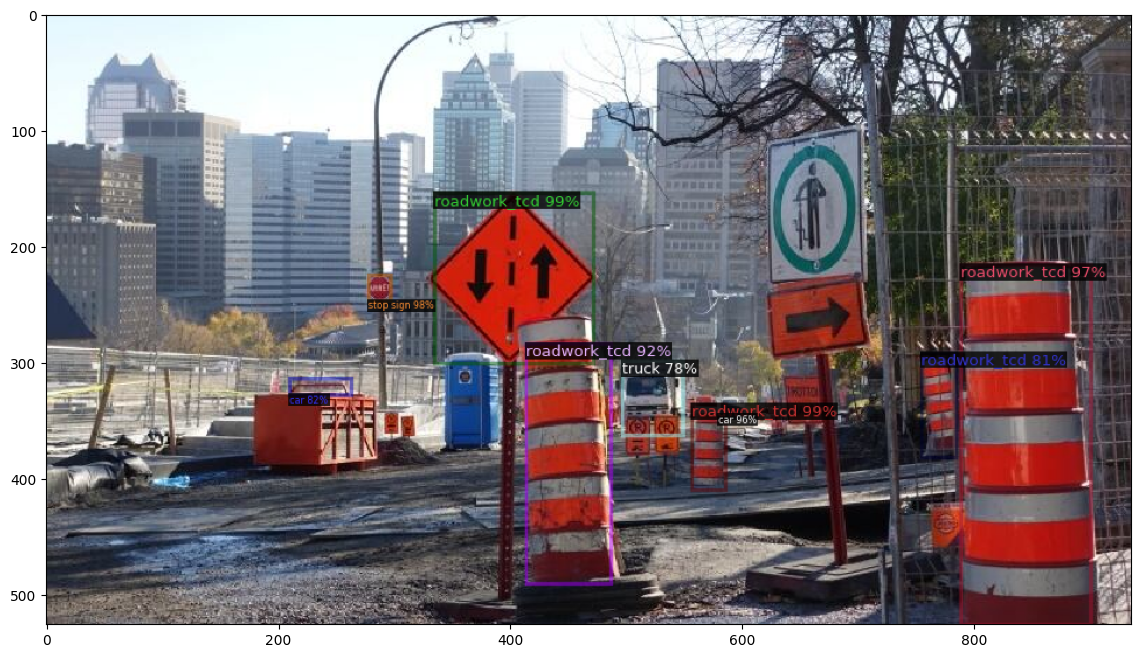

In [6]:
outputs = predictor(im1)
v = Visualizer(im1[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [7]:
outputs

{'instances': Instances(num_instances=9, image_height=439, image_width=780, fields=[pred_boxes: Boxes(tensor([[464.1169, 280.3798, 488.2251, 342.5029],
         [278.7838, 128.7886, 393.3716, 251.4632],
         [231.7239, 188.4208, 247.6427, 206.1937],
         [657.1975, 180.3402, 750.6791, 439.0000],
         [483.5226, 276.2149, 502.2301, 287.9721],
         [345.0515, 236.9837, 406.1517, 409.6302],
         [175.3726, 262.5390, 219.1532, 274.1506],
         [629.0875, 243.6391, 654.0002, 318.8644],
         [413.9905, 249.8615, 457.2470, 303.2968]], device='cuda:0')), scores: tensor([0.9916, 0.9902, 0.9767, 0.9666, 0.9627, 0.9176, 0.8152, 0.8081, 0.7768],
        device='cuda:0'), pred_classes: tensor([ 7,  7,  9,  7,  2,  7,  2,  7, 11], device='cuda:0')])}

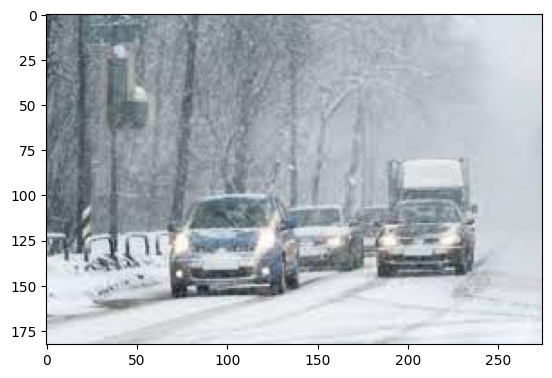

In [8]:
im2 = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/snow_road.jpeg")
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


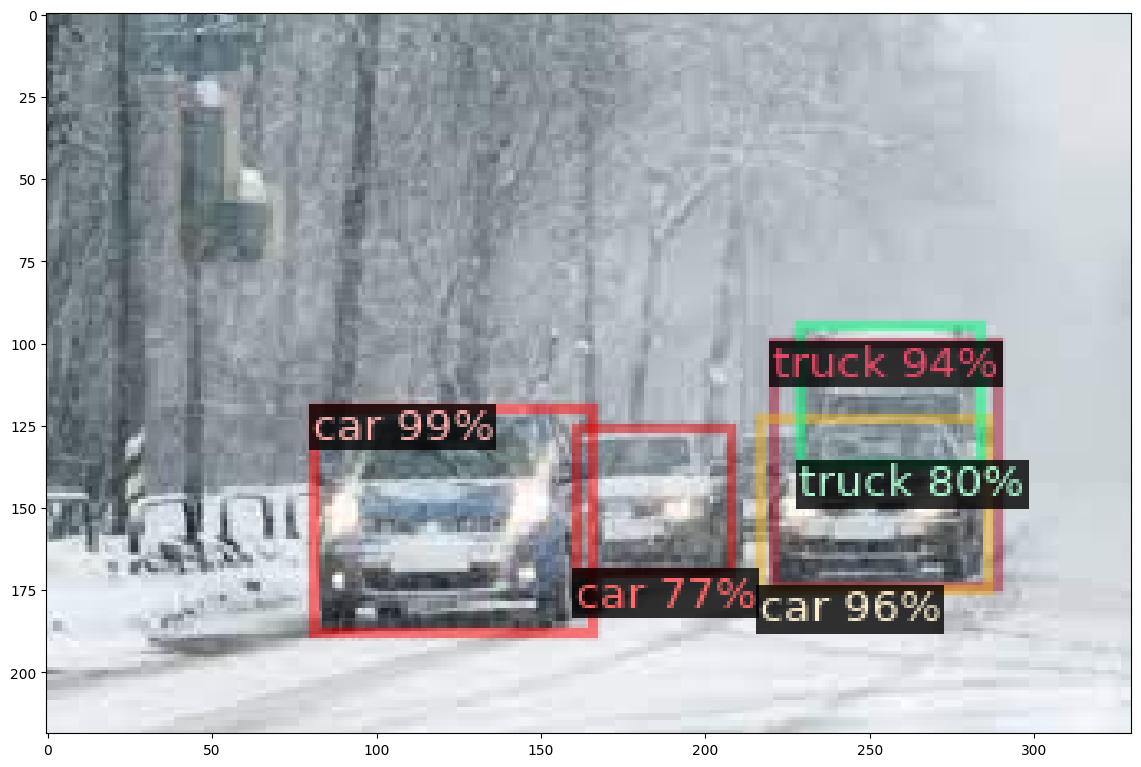

In [9]:
outputs = predictor(im2)
v = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [10]:
outputs

{'instances': Instances(num_instances=5, image_height=183, image_width=275, fields=[pred_boxes: Boxes(tensor([[ 67.1511, 100.1345, 138.4320, 157.1033],
         [180.9643, 103.1718, 238.4671, 146.2299],
         [184.5090,  84.2078, 240.9263, 145.7930],
         [190.8258,  79.8071, 236.4378, 114.3098],
         [133.8423, 105.2533, 173.0858, 142.3459]], device='cuda:0')), scores: tensor([0.9899, 0.9636, 0.9396, 0.8038, 0.7746], device='cuda:0'), pred_classes: tensor([ 2,  2, 11, 11,  2], device='cuda:0')])}

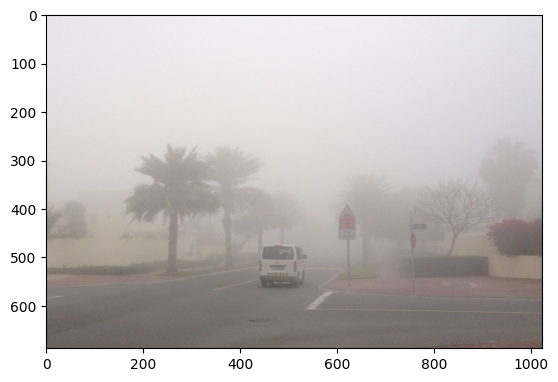

In [11]:
im3 = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/Topic-Pic-Bad-Weather.jpg")
plt.imshow(cv2.cvtColor(im3, cv2.COLOR_BGR2RGB))

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


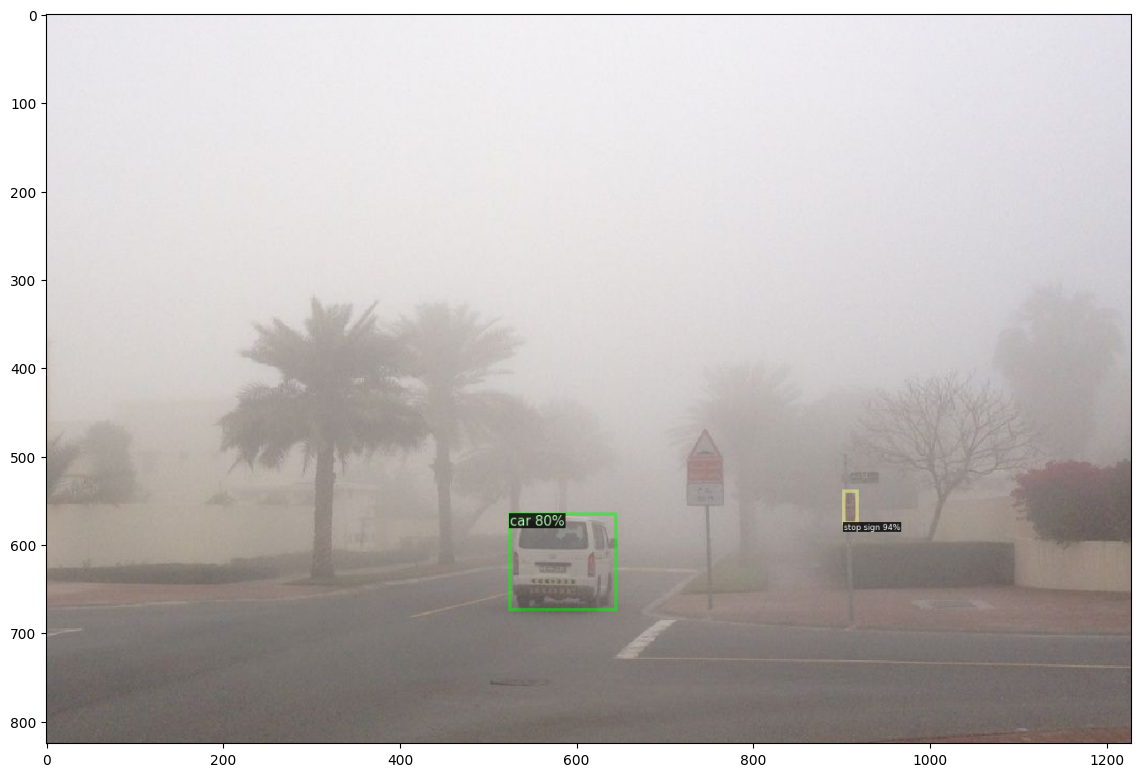

In [12]:
outputs = predictor(im3)
v = Visualizer(im3[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [13]:
outputs

{'instances': Instances(num_instances=2, image_height=688, image_width=1024, fields=[pred_boxes: Boxes(tensor([[752.4339, 450.8427, 764.9161, 480.7765],
         [437.6473, 472.3718, 537.2401, 562.3170]], device='cuda:0')), scores: tensor([0.9428, 0.7999], device='cuda:0'), pred_classes: tensor([9, 2], device='cuda:0')])}

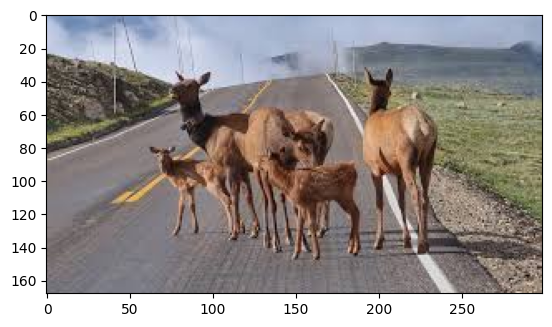

In [12]:
im4 = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/deer_road.jpeg")
plt.imshow(cv2.cvtColor(im4, cv2.COLOR_BGR2RGB))

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


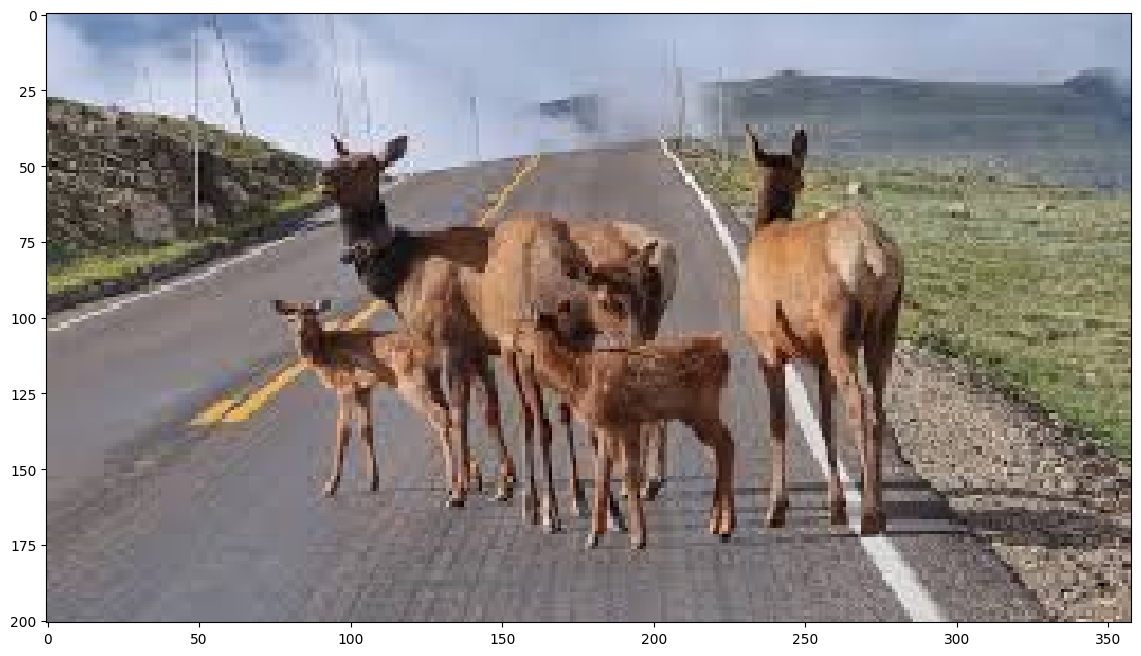

In [22]:
outputs = predictor(im4)
v = Visualizer(im4[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [23]:
outputs

{'instances': Instances(num_instances=0, image_height=168, image_width=299, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}